**IoU weighted block F1**

In [10]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
from collections import defaultdict
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

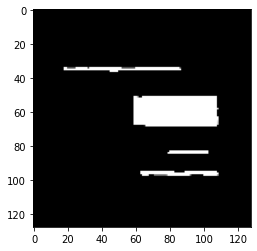

In [ ]:
#view ground truth
test_img = cv2.imread('76.png', cv2.IMREAD_COLOR)       
test_img = cv2.resize(test_img, (128, 128))
test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
plt.imshow(test_img, cmap='gray')
#test_img = np.expand_dims(test_img, axis=0)
vb_truth = np.array(test_img)
truthList = vb_truth.tolist()

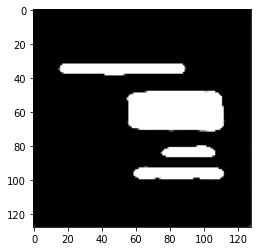

In [ ]:
#view prediction
pred = cv2.imread('predOf76-unetlt.png', cv2.IMREAD_COLOR)       
pred = cv2.resize(pred, (128, 128))
pred = cv2.cvtColor(pred, cv2.COLOR_RGB2BGR)
plt.imshow(pred, cmap='gray')
#pred = np.expand_dims(pred, axis=0)
vb_pred = np.array(pred)
predList = vb_pred.tolist()

In [ ]:
# make a 1-dimensional view of arr
vb_truth = vb_truth.ravel()
vb_pred = vb_pred.ravel()

print(vb_truth)
print(vb_pred)

[0 0 0 ... 0 0 0]
[32 32 32 ... 73 73 73]


In [ ]:
#vb_truth = vb_truth[vb_truth != 0]
#vb_pred = vb_pred[vb_pred != 0]

vb_truth = vb_truth[vb_truth == 255]
vb_pred = vb_pred[vb_pred == 255]

In [ ]:
#vb_truth, vb_pred = [1,2,1,3,3,5], [1,1,2,3,4,3,1]


def make_index(split):
    l= sum(split)
    pages= list(np.arange(l))
    out = defaultdict(set)
    for block_length in split:
        block= pages[:block_length]
        pages= pages[block_length:]
        for page in block:
            out[page]= set(block)
    return out

#test
make_index(vb_truth)
#tests

In [ ]:
def IoU_TruePositives(t,h):
    '''A True Positive is a pair h_block, t_block with an IoU>.5.
    This function returns the sum of all IoUs(h_block,t_block) for these bvlocks in t and h,
    and the sets of TPs, FPs and FNs.'''
    def IoU(S,T):
        '''Jaccard similarity between sets S and T'''
        return len(S&T)/len(S|T)
    def get_docs(t):
        '''Get the set of documents (where each document is a set of pagenumbers)'''
        return {frozenset(S) for S in make_index(t).values()}
    def find_match(S,Candidates):
        '''Finds, if it exists,  the unique T in Candidates such that IoU(S,T) >.5'''
        return [T for T in Candidates if IoU(S,T) >.5]
    t,h= get_docs(t), get_docs(h) # switch to set of docs representation
    TP= {(S,find_match(S,t)[0]) for S in h if find_match(S,t)}
    FP= h-{S for (S,_) in TP}
    FN= t- {T for (_,T) in TP} 
    return sum(IoU(S,T) for (S,T) in TP  ), TP, FP, FN 

IoU_TruePositives(vb_truth, vb_pred)

In [ ]:
def IoU_P(t,h):
    return IoU_TruePositives(t,h)[0]/len(h)
def IoU_R(t,h):
    return IoU_TruePositives(t,h)[0]/len(t)
def IoU_F1(t,h):
    P,R= IoU_P(t,h),IoU_R(t,h)
    TPS,TP,FP,FN=  IoU_TruePositives(t,h)
    return 0 if (P+R)==0 else 2*P*R/(P+R) #  TPS/(len(TP)+ .5*(len(FP)+len(FN))) # gives the same answer
     

IoU_P(vb_truth,vb_pred),IoU_R(vb_truth,vb_pred),IoU_F1(vb_truth,vb_pred)

In [ ]:
"""
#the results of the tests:

# first image 76
IoU_P 0.5280693747147421
IoU_R 1.0
IoU_F1 0.6911589008363201

# 2nd image 77
IoU_P 0.4598997493734336
IoU_R 1.0
IoU_F1 0.6300429184549357

# Third image 10
IoU_P 0.3388704318936877
IoU_R 1.0
IoU_F1 0.5062034739454094

#Forth image 52
IoU_P 0.2591185410334346
IoU_R 1.0
IoU_F1 0.41158720579360286

# Fifth image 21
IoU_P 0.4495359628770302
IoU_R 1.0
IoU_F1 0.6202480992396959

"""

In [15]:

import statistics

# array of IoU_F1 scores
data = [0.6911589008363201, 0.6300429184549357, 0.5062034739454094, 0.41158720579360286, 0.6202480992396959]

numberOfPages = len(data)
print('number Of Pages: ' ,numberOfPages)

meann = statistics.mean(data)
print('Mean' ,meann)

std = statistics.stdev(data)
print('Stdev', std)


mi = np.array(data)
print('Min',mi.min())


ma = np.array(data)
print('Max',ma.max())



number Of Pages:  5
Mean 0.5718481196539928
Stdev 0.11175535239898876
Min 0.41158720579360286
Max 0.6911589008363201


In [ ]:
def translate(doclengths):
    if not doclengths:
        return []
    else:
        dl1= doclengths[0]
        return [1]+[0 for _ in range(dl1-1)]+ translate(doclengths[1:])
    
def fixedpage(file,docsize=3):
    number_of_blocks= len(file)//docsize
    rest = len(file) % docsize
    first= [docsize for _ in range(number_of_blocks)]
    if rest !=0:
        return translate(first+[rest])
    else:
        return translate(first )

f= open('Doclengths_of_the_individual_docs.json')
truth_corpus=json.load(f)    
    
D ={pdf: IoU_F1(truth_corpus[pdf], fixedpage(truth_corpus[pdf],2))
   for pdf in truth_corpus}
results= pd.DataFrame.from_dict(D,orient='index')
results.columns=['IoU_F1 for fixed page baseline of size 2']
#print(results.shape)
#print(results.head())
print(results.describe())
sns.boxplot(data=results);